In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import models, layers
import gc # garbage collections
import bz2 # to open zipped files

# Loading the dataset

In [4]:
train = bz2.BZ2File('../input/amazonreviews/train.ft.txt.bz2')
test = bz2.BZ2File('../input/amazonreviews/test.ft.txt.bz2')

In [5]:
train = train.readlines()
test = test.readlines()

train[0]

b'__label__2 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^\n'

In [6]:
# convert from raw binary strings into text files that can be parsed

train = [x.decode('utf-8') for x in train]
test = [x.decode('utf-8') for x in test]

In [7]:
train[0]

'__label__2 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^\n'

In [8]:
print(type(train), type(test), "\n")

print(f"Train Data Volume: {len(train)}\n")
print(f"Test Data Volume: {len(test)}\n\n")

print("Demo: ", "\n")
for x in train[:5]:
    print(x, "\n")

<class 'list'> <class 'list'> 

Train Data Volume: 3600000

Test Data Volume: 400000


Demo:  

__label__2 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^
 

__label__2 The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, thi

In [9]:
# extract labels from the dataset
# judging from the dataset, let's set 0 for negative sentiment and 1 for positive sentiment

train_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in train] 
test_labels = [0 if x.split(' ')[0] =='__label__1' else 1 for x in test]

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Train Labels Distribution')

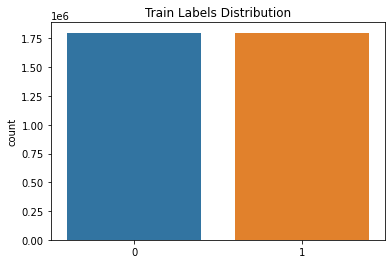

In [10]:
sns.countplot(train_labels)
plt.title('Train Labels Distribution')

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Test Labels Distribution')

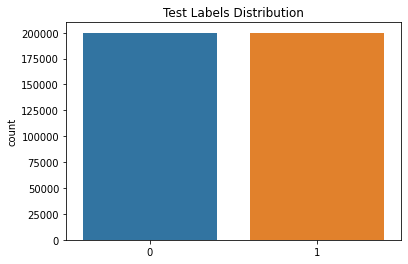

In [11]:
sns.countplot(test_labels)
plt.title('Test Labels Distribution')

In [12]:
# let's extract the texts

train_texts = [x.split(' ', maxsplit=1)[1][:-1] for x in train]
test_texts = [x.split(' ', maxsplit=1)[1][:-1] for x in test]

train_texts[0]

'Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'

In [13]:
del train, test

gc.collect()

70

## Exploratory Data Analysis

### Word Cloud

In [14]:
from wordcloud import WordCloud

In [15]:
# let's have a corpus for all the texts in train_text

corpus = ' '.join(text for text in train_texts[:100000])
print(f'There are {len(corpus)} words in the corpus')

There are 44053838 words in the corpus


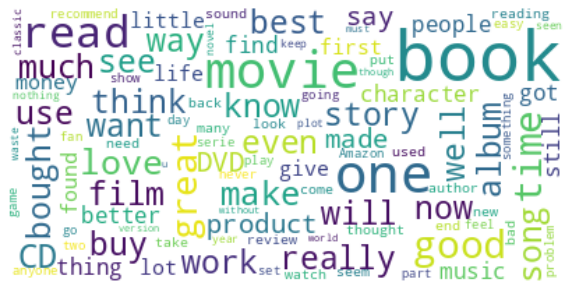

In [16]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color='white')
wordcloud = wordcloud.generate(corpus)


plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

In [17]:
del wordcloud

gc.collect()

3202

### Distribution of word count

Text(0.5, 1.0, 'Word Frequency Distribution in Reviews')

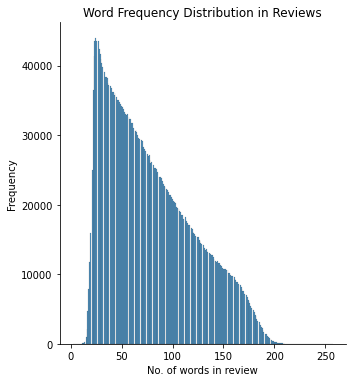

In [18]:
# let's count the number of words in the review and see the distribution

train_texts_size = list(map(lambda x: len(x.split()), train_texts))
sns.displot(train_texts_size)
plt.xlabel('No. of words in review')
plt.ylabel('Frequency')
plt.title('Word Frequency Distribution in Reviews')

In [19]:
train_size_df = pd.DataFrame({'len': train_texts_size, 'labels': train_labels})
train_size_df.head(10)

,len,labels
0,80,1
1,97,1
2,129,1
3,118,1
4,87,1
5,142,1
6,139,0
7,105,1
8,103,1
9,63,1


Negative mean length: 81.50
Positive mean length:  75.46
Mean difference: 6.04


Text(0.5, 6.79999999999999, 'Label -> 0 for Negative and 1 for Positive')

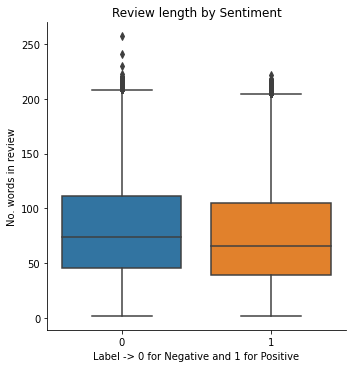

In [20]:
neg_mean_len = train_size_df[train_size_df['labels'] == 0]['len'].mean()
pos_mean_len = train_size_df[train_size_df['labels'] == 1]['len'].mean()

print(f'Negative mean length: {neg_mean_len:.2f}')
print(f'Positive mean length: {pos_mean_len: .2f}')
print(f'Mean difference: {neg_mean_len - pos_mean_len:.2f}')

sns.catplot(x='labels', y='len', data=train_size_df, kind='box')
plt.title('Review length by Sentiment')
plt.ylabel('No. words in review')
plt.xlabel('Label -> 0 for Negative and 1 for Positive')

In [21]:
del train_size_df

gc.collect()

107

## Tokenizing and Vectorizing

In [22]:
len(train_texts), len(test_texts)

(3600000, 400000)

In [23]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

num_words = 70000 # number of words from the train_text to tokenize by frequency
tokenizer = Tokenizer(num_words = num_words)
tokenizer.fit_on_texts(train_texts)

# let's see the dictionary of words tokenized

word_index = tokenizer.word_index
print(f'The size of the vocabulary: {len(word_index)}')
word_index

The size of the vocabulary: 1103003


{'the': 1,
 'and': 2,
 'i': 3,
 'a': 4,
 'to': 5,
 'it': 6,
 'of': 7,
 'this': 8,
 'is': 9,
 'in': 10,
 'for': 11,
 'that': 12,
 'was': 13,
 'not': 14,
 'you': 15,
 'but': 16,
 'with': 17,
 'on': 18,
 'book': 19,
 'have': 20,
 'my': 21,
 'as': 22,
 'are': 23,
 'one': 24,
 'be': 25,
 'so': 26,
 'all': 27,
 'if': 28,
 'great': 29,
 'very': 30,
 'good': 31,
 'like': 32,
 'they': 33,
 'at': 34,
 'just': 35,
 'from': 36,
 'or': 37,
 'would': 38,
 'out': 39,
 'about': 40,
 'an': 41,
 'me': 42,
 'has': 43,
 'what': 44,
 'more': 45,
 'had': 46,
 'will': 47,
 'read': 48,
 'when': 49,
 "it's": 50,
 'get': 51,
 'no': 52,
 'up': 53,
 'by': 54,
 'time': 55,
 'there': 56,
 'only': 57,
 'your': 58,
 'can': 59,
 'movie': 60,
 'he': 61,
 'his': 62,
 "don't": 63,
 'really': 64,
 'some': 65,
 'do': 66,
 'well': 67,
 'than': 68,
 'them': 69,
 'who': 70,
 'much': 71,
 'even': 72,
 'first': 73,
 'other': 74,
 'we': 75,
 'these': 76,
 'her': 77,
 'after': 78,
 'love': 79,
 'because': 80,
 'buy': 81,
 'too': 

In [24]:
# let's save the tokenizer for future use

import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
#with open('tokenizer.pickle', 'rb') as handle:
   # tokenizer = pickle.load(handle)

In [25]:
sequences = tokenizer.texts_to_sequences(train_texts)
print(len(sequences))

# pad sequences to the same shape
maxlen = 100
sequences = pad_sequences(sequences, maxlen=maxlen)

3600000


In [26]:
sequences[0].shape

(100,)

In [27]:
train_texts[0]

'Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'

In [28]:
len(train_labels)

3600000

In [29]:
# let's convert to numpy array
import numpy as np

labels = np.array(train_labels)

In [30]:
# let's reduce the dataset size...
# train_texts should be 400,000 and test_text should be 20,000

# first we shuffle numbers from & 400000

indices = np.arange(len(train_texts))
np.random.shuffle(indices)
train_data = sequences[indices]
train_labels = labels[indices]

In [31]:
train_size = 600000
train_data = train_data[:train_size]
train_labels = train_labels[:train_size]

In [32]:
# let's split the dataset
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(train_data, train_labels, random_state=42, test_size=0.2)

In [33]:
len(X_train), len(X_valid)

(480000, 120000)

In [34]:
X_train.shape

(480000, 100)

In [35]:
# sanity check

sanity_text = tokenizer.sequences_to_texts(sequences[:3])
sanity_text

['even for the non gamer this sound track was beautiful it paints the in your mind so well i would recomend it even to people who hate vid game music i have played the game chrono cross but out of all of the games i have ever played it has the best music it backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras it would impress anyone who cares to listen',
 "the best soundtrack ever to anything i'm reading a lot of reviews saying that this is the best and i figured that i'd write a review to disagree a bit this in my is ultimate masterpiece the music is timeless and i'm been listening to it for years now and its beauty simply refuses to fade the price tag on this is pretty staggering i must say but if you are going to buy any cd for this much money this is the only one that i feel would be worth every penny",
 "the game and the hope in a distant promise and girl who stole the star have been an important inspiration to me personally througho

In [36]:
train_texts[:3]

['Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^',
 "The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.",
 'Amazing!: This soundtrack is my favorite music of all

In [37]:
sanity_text = tokenizer.sequences_to_texts(X_train[:3])
sanity_text

['jeeves and wooster dvds this season is as enjoyable as the first two wooster geat into even more trouble as jeeves gets him out of it again a wonderfull comedy combo',
 "meh 1 2 stars the noisy beginings of jimmy eat world here the bands major label debut showcases the begining stages but here they dont sound anything like what they've become here the band dabbles in noisey emotive punk and some dabbles in post hardcore the songs arent particularly tuneful but the is defiently evident here in this of songs jim adkins voice here is virtually to his signature tenor of late a similar case with silverchair getting more and more tuneful as time went on this is probablly not something you should start off with this band",
 "gps cobra dont work gps cobra did not work high pitch sound and screen didn't come on they didnt check to be shere it worked before they shipped it"]

All works and we can see most of the texts from each review is kept

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Test Labels Distribution')

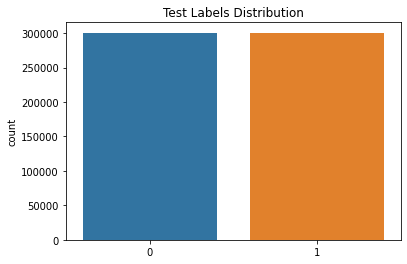

In [38]:
sns.countplot(train_labels)
plt.title('Test Labels Distribution')

In [39]:
del sequences, train_texts, train_data

gc.collect()

24

### Preprocessing the Test set

In [40]:
len(test_texts)

400000

In [41]:
# convert test_labels to numpy arrays
test_labels = np.array(test_labels)

# vectorize the test set
test = tokenizer.texts_to_sequences(test_texts)

# pad the sequence 
test = pad_sequences(test, maxlen=maxlen)

In [42]:
# let's reduce the dataset size
indices = np.arange(len(test_texts))
np.random.shuffle(indices)
test = test[indices]
test_labels = test_labels[indices]

test_size = 50000
test = test[:test_size]
test_labels = test_labels[:test_size]

In [43]:
# sanity check

print(test_texts[:3])
print('\n')
print(tokenizer.sequences_to_texts(test[:3]))

['Great CD: My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT. When I\'m in a good mood it makes me feel better. A bad mood just evaporates like sugar in the rain. This CD just oozes LIFE. Vocals are jusat STUUNNING and lyrics just kill. One of life\'s hidden gems. This is a desert isle CD in my book. Why she never made it big is just beyond me. Everytime I play this, no matter black, white, young, old, male, female EVERYBODY says one thing "Who was that singing ?"', "One of the best game music soundtracks - for a game I didn't really play: Despite the fact that I have only played a small portion of the game, the music I heard (plus the connection to Chrono Trigger which was great as well) led me to purchase the soundtrack, and it remains one of my favorite albums. There is an incredible mix of fun, epic, and emotional songs. Those sad and beautiful tracks I especially like, as there's not too many of those kinds of so

# ML Models

## Baseline Model

In [44]:
embedding_dim = 100

In [45]:
model = models.Sequential(name='baseline_amazon')
model.add(layers.Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(64, 7, padding='valid', activation='relu'))
model.add(layers.Conv1D(128, 7, padding='valid', activation='relu'))
model.add(layers.Conv1D(256, 7, padding='valid', activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

2022-04-06 22:58:46.611999: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-06 22:58:46.700639: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-06 22:58:46.701366: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-06 22:58:46.702542: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [46]:
model.summary()

Model: "baseline_amazon"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          7000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 94, 64)            44864     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 88, 128)           57472     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 82, 256)           229632    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)           

In [47]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True), 
             keras.callbacks.ModelCheckpoint('baseline.h5', save_best_only=True)]

In [48]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), callbacks=callbacks)

2022-04-06 22:59:13.009733: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-04-06 22:59:14.488262: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


15000/15000 [==============================] - 106s 7ms/step - loss: 0.2392 - accuracy: 0.9011 - val_loss: 0.2035 - val_accuracy: 0.9220
Epoch 2/30
15000/15000 [==============================] - 99s 7ms/step - loss: 0.1629 - accuracy: 0.9387 - val_loss: 0.1972 - val_accuracy: 0.9227
Epoch 3/30
15000/15000 [==============================] - 99s 7ms/step - loss: 0.1163 - accuracy: 0.9583 - val_loss: 0.2208 - val_accuracy: 0.9178
Epoch 4/30
15000/15000 [==============================] - 99s 7ms/step - loss: 0.0773 - accuracy: 0.9736 - val_loss: 0.2351 - val_accuracy: 0.9156
Epoch 5/30
15000/15000 [==============================] - 95s 6ms/step - loss: 0.0510 - accuracy: 0.9834 - val_loss: 0.2784 - val_accuracy: 0.9056
Epoch 6/30
15000/15000 [==============================] - 94s 6ms/step - loss: 0.0349 - accuracy: 0.9888 - val_loss: 0.3303 - val_accuracy: 0.9083
Epoch 7/30
15000/15000 [==============================] - 95s 6ms/step - loss: 0.0269 - accuracy: 0.9913 - val_loss: 0.4569 - va

In [49]:
def learning_curve(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(1, len(loss) + 1)

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Train Loss')
    plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
    plt.title('Train and Validation Loss')
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy, 'bo', label='Train Accuracy')
    plt.plot(epochs, val_accuracy, 'b-', label='Validation Accuracy')
    plt.title('Train and Validation Accuracy')
    plt.legend()

    plt.show()

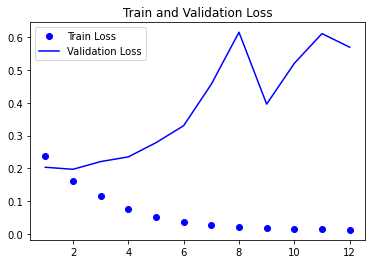

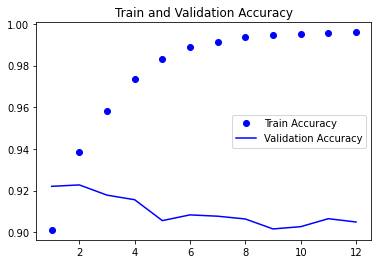

In [50]:
learning_curve(history)

In [51]:
# let's evaluate the model's result on the test set

loss_1, acc_1 = model.evaluate(test, test_labels)
loss_1, acc_1

1563/1563 [==============================] - 5s 3ms/step - loss: 0.1994 - accuracy: 0.9220


(0.19938941299915314, 0.9220399856567383)

## Baseline Model + BatchNorm & Higher Dropout

In [52]:
model = models.Sequential(name='baseline2_amazon')
model.add(layers.Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=maxlen))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(64, 7, padding='valid', use_bias=False))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Conv1D(128, 7, padding='valid', use_bias=False))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(128, use_bias=False))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [53]:
model.summary()

Model: "baseline2_amazon"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          7000000   
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100)          400       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 94, 64)            44800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 94, 64)            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 94, 64)            256       
_________________________________________________________________
activation (Activation)      (None, 94, 64)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 88, 128)      

In [55]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True), 
             keras.callbacks.ModelCheckpoint('baseline2.h5', save_best_only=True)]

history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), callbacks=callbacks)

Epoch 1/30
15000/15000 [==============================] - 99s 6ms/step - loss: 0.2613 - accuracy: 0.8930 - val_loss: 0.2115 - val_accuracy: 0.9173
Epoch 2/30
15000/15000 [==============================] - 101s 7ms/step - loss: 0.1942 - accuracy: 0.9249 - val_loss: 0.2034 - val_accuracy: 0.9236
Epoch 3/30
15000/15000 [==============================] - 102s 7ms/step - loss: 0.1550 - accuracy: 0.9428 - val_loss: 0.2011 - val_accuracy: 0.9211
Epoch 4/30
15000/15000 [==============================] - 98s 7ms/step - loss: 0.1242 - accuracy: 0.9556 - val_loss: 0.2111 - val_accuracy: 0.9169
Epoch 5/30
15000/15000 [==============================] - 98s 7ms/step - loss: 0.1005 - accuracy: 0.9650 - val_loss: 0.2174 - val_accuracy: 0.9146
Epoch 6/30
15000/15000 [==============================] - 102s 7ms/step - loss: 0.0815 - accuracy: 0.9723 - val_loss: 0.2402 - val_accuracy: 0.9106
Epoch 7/30
15000/15000 [==============================] - 102s 7ms/step - loss: 0.0699 - accuracy: 0.9765 - val_los

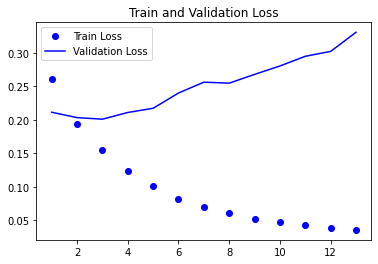

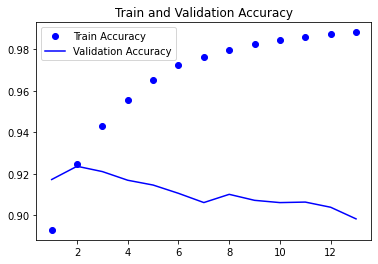

In [56]:
learning_curve(history)

In [57]:
loss_2, acc_2 = model.evaluate(test, test_labels)
loss_2, acc_2

1563/1563 [==============================] - 4s 3ms/step - loss: 0.2052 - accuracy: 0.9196


(0.20520655810832977, 0.9195600152015686)

### Model 3 - LSTM

In [58]:
model = models.Sequential(name='lstm_amazon')
model.add(layers.Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=maxlen))
model.add(layers.LSTM(64, dropout=0.2, return_sequences=False))
model.add(layers.Dense(1, activation='sigmoid'))

In [59]:
model.summary()

Model: "lstm_amazon"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          7000000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 7,042,305
Trainable params: 7,042,305
Non-trainable params: 0
_________________________________________________________________


In [60]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=False), 
             keras.callbacks.ModelCheckpoint('lstm_amazon.h5', save_best_only=True)]

history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid), callbacks=callbacks)

Epoch 1/20
15000/15000 [==============================] - 138s 9ms/step - loss: 0.2285 - accuracy: 0.9083 - val_loss: 0.1833 - val_accuracy: 0.9281
Epoch 2/20
15000/15000 [==============================] - 126s 8ms/step - loss: 0.1563 - accuracy: 0.9406 - val_loss: 0.1766 - val_accuracy: 0.9321
Epoch 3/20
15000/15000 [==============================] - 126s 8ms/step - loss: 0.1195 - accuracy: 0.9562 - val_loss: 0.1944 - val_accuracy: 0.9292
Epoch 4/20
15000/15000 [==============================] - 125s 8ms/step - loss: 0.0921 - accuracy: 0.9672 - val_loss: 0.2097 - val_accuracy: 0.9264
Epoch 5/20
15000/15000 [==============================] - 127s 8ms/step - loss: 0.0715 - accuracy: 0.9754 - val_loss: 0.2459 - val_accuracy: 0.9242
Epoch 6/20
15000/15000 [==============================] - 126s 8ms/step - loss: 0.0573 - accuracy: 0.9806 - val_loss: 0.2812 - val_accuracy: 0.9193
Epoch 7/20
15000/15000 [==============================] - 126s 8ms/step - loss: 0.0469 - accuracy: 0.9842 - val_

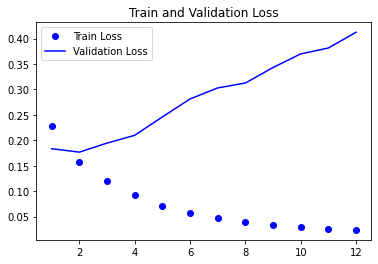

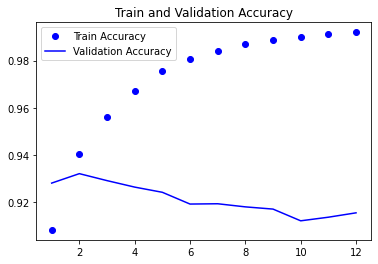

In [61]:
learning_curve(history)

In [62]:
loss_3, acc_3 = model.evaluate(test, test_labels)
loss_3, acc_3

1563/1563 [==============================] - 6s 4ms/step - loss: 0.4213 - accuracy: 0.9132


(0.4212523102760315, 0.9131799936294556)

### Bidirectional LSTM

In [63]:
model = models.Sequential(name='bidirectional_lstm')
model.add(layers.Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=maxlen))
model.add(layers.Bidirectional(layers.LSTM(64, dropout=0.2, return_sequences=False)))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [64]:
model.summary()

Model: "bidirectional_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          7000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 7,092,801
Trainable params: 7,092,801
Non-trainable params: 0
_________________________________________________________________


In [65]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=False), 
             keras.callbacks.ModelCheckpoint('bilstm_amazon.h5', save_best_only=True)]

history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid), callbacks=callbacks)

Epoch 1/20
15000/15000 [==============================] - 198s 13ms/step - loss: 0.2314 - accuracy: 0.9078 - val_loss: 0.1879 - val_accuracy: 0.9260
Epoch 2/20
15000/15000 [==============================] - 195s 13ms/step - loss: 0.1594 - accuracy: 0.9406 - val_loss: 0.1788 - val_accuracy: 0.9306
Epoch 3/20
15000/15000 [==============================] - 195s 13ms/step - loss: 0.1229 - accuracy: 0.9559 - val_loss: 0.1865 - val_accuracy: 0.9307
Epoch 4/20
15000/15000 [==============================] - 195s 13ms/step - loss: 0.0937 - accuracy: 0.9674 - val_loss: 0.2105 - val_accuracy: 0.9262
Epoch 5/20
15000/15000 [==============================] - 195s 13ms/step - loss: 0.0711 - accuracy: 0.9755 - val_loss: 0.2393 - val_accuracy: 0.9238
Epoch 6/20
15000/15000 [==============================] - 195s 13ms/step - loss: 0.0567 - accuracy: 0.9809 - val_loss: 0.2804 - val_accuracy: 0.9209
Epoch 7/20
15000/15000 [==============================] - 195s 13ms/step - loss: 0.0460 - accuracy: 0.9845

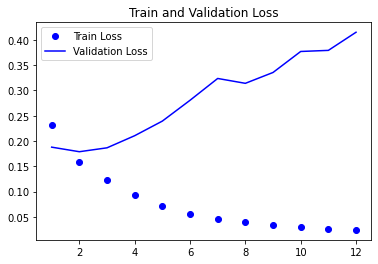

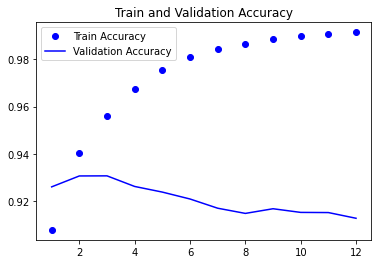

In [66]:
learning_curve(history)

In [67]:
loss_4, acc_4 = model.evaluate(test, test_labels)
loss_4, acc_4

1563/1563 [==============================] - 9s 6ms/step - loss: 0.4269 - accuracy: 0.9111


(0.426885187625885, 0.9111400246620178)

## Using Pretrained glove Embeddings

In [68]:
model = models.Sequential(name='pretrained_embeddings')
model.add(layers.Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=maxlen))
model.add(layers.LSTM(64, dropout=0.2, return_sequences=False))
model.add(layers.Dense(1, activation='sigmoid'))

In [69]:
model.summary()

Model: "pretrained_embeddings"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          7000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 7,042,305
Trainable params: 7,042,305
Non-trainable params: 0
_________________________________________________________________


In [70]:
# we need to use the glove embeddings to set the weights of the Embedding layer

embedding_path = '../input/glove6b100dtxt/glove.6B.100d.txt'

# create a dictionary to store the index
embedding_index = {}
f = open(embedding_path)

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.array(values[1:], dtype='float32')
    embedding_index[word] = coefs

f.close()
print(f'There are {len(embedding_index)} words found')

There are 400000 words found


In [71]:
# initialize an zero matrix of shape (num_words, embedding_dim)

embedding_matrix = np.zeros((num_words, embedding_dim))

for word, index in word_index.items():
    if index < num_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector # maps each index in our word_index to its glove embeddings

In [72]:
embedding_matrix[0].shape

(100,)

In [73]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [74]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
callbacks = [keras.callbacks.EarlyStopping(patience=15, restore_best_weights=False), 
             keras.callbacks.ModelCheckpoint('glove_amazon.h5', save_best_only=True)]

history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), callbacks=callbacks)

Epoch 1/30
15000/15000 [==============================] - 96s 6ms/step - loss: 0.3153 - accuracy: 0.8624 - val_loss: 0.2469 - val_accuracy: 0.8984
Epoch 2/30
15000/15000 [==============================] - 96s 6ms/step - loss: 0.2446 - accuracy: 0.8986 - val_loss: 0.2152 - val_accuracy: 0.9126
Epoch 3/30
15000/15000 [==============================] - 95s 6ms/step - loss: 0.2258 - accuracy: 0.9080 - val_loss: 0.2064 - val_accuracy: 0.9165
Epoch 4/30
15000/15000 [==============================] - 96s 6ms/step - loss: 0.2158 - accuracy: 0.9128 - val_loss: 0.2000 - val_accuracy: 0.9193
Epoch 5/30
15000/15000 [==============================] - 96s 6ms/step - loss: 0.2105 - accuracy: 0.9152 - val_loss: 0.1970 - val_accuracy: 0.9214
Epoch 6/30
15000/15000 [==============================] - 96s 6ms/step - loss: 0.2055 - accuracy: 0.9173 - val_loss: 0.2023 - val_accuracy: 0.9195
Epoch 7/30
15000/15000 [==============================] - 96s 6ms/step - loss: 0.2020 - accuracy: 0.9190 - val_loss: 0

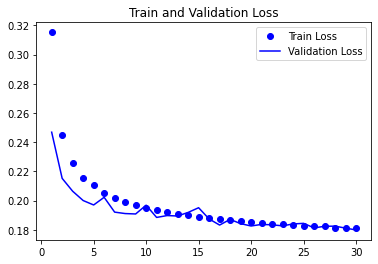

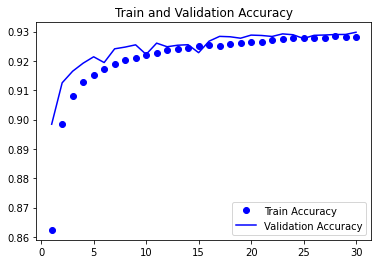

In [75]:
learning_curve(history)

In [76]:
loss_5, acc_5 = model.evaluate(test, test_labels)
loss_5, acc_5

1563/1563 [==============================] - 6s 4ms/step - loss: 0.1860 - accuracy: 0.9285


(0.18602396547794342, 0.9284600019454956)

## Using Transformer Architecture From Scratch

In [77]:
# create the transformer block

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads = num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([layers.Dense(ff_dim, activation='relu'), layers.Dense(embed_dim),])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# implement the embedding layer

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim = embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [78]:
# parameters for training
embed_dim = 100
num_heads = 2
ff_dim = 32
vocab_size = 70000

# create the model
inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation='relu')(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=inputs, outputs = outputs)

In [81]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
15000/15000 [==============================] - 107s 7ms/step - loss: 0.1211 - accuracy: 0.9545 - val_loss: 0.3088 - val_accuracy: 0.8931
Epoch 2/10
15000/15000 [==============================] - 110s 7ms/step - loss: 0.1044 - accuracy: 0.9614 - val_loss: 0.3642 - val_accuracy: 0.8862
Epoch 3/10
15000/15000 [==============================] - 110s 7ms/step - loss: 0.0901 - accuracy: 0.9672 - val_loss: 0.4202 - val_accuracy: 0.8836
Epoch 4/10
15000/15000 [==============================] - 107s 7ms/step - loss: 0.0772 - accuracy: 0.9721 - val_loss: 0.4601 - val_accuracy: 0.8835
Epoch 5/10
15000/15000 [==============================] - 106s 7ms/step - loss: 0.0670 - accuracy: 0.9760 - val_loss: 0.4896 - val_accuracy: 0.8868
Epoch 6/10
15000/15000 [==============================] - 111s 7ms/step - loss: 0.0589 - accuracy: 0.9792 - val_loss: 0.5226 - val_accuracy: 0.8845
Epoch 7/10
15000/15000 [==============================] - 110s 7ms/step - loss: 0.0524 - accuracy: 0.9815 - val_

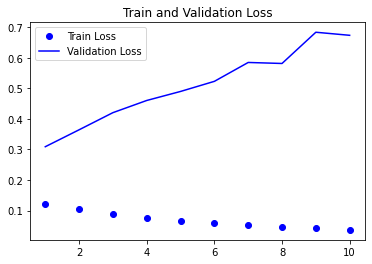

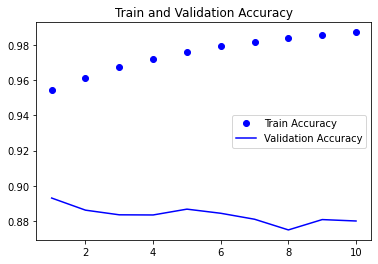

In [82]:
learning_curve(history)

In [83]:
loss_6, acc_6 = model.evaluate(test, test_labels)
loss_6, acc_6

1563/1563 [==============================] - 6s 4ms/step - loss: 0.6973 - accuracy: 0.8781


(0.6972763538360596, 0.878059983253479)

In [84]:
result = pd.DataFrame({'loss': [loss_1, loss_2, loss_3, loss_4, loss_5, loss_6], 
                      'accuracy': [acc_1, acc_2, acc_3, acc_4, acc_5, acc_6], 
                      }, index = ['Baseline', 'Baseline with dropout', 'LSTM Model', 'Bidirectional LSTM',
                                 'Pretrained Embeddings', 'Transformers from Scratch'])
result

,loss,accuracy
Baseline,0.199389,0.92204
Baseline with dropout,0.205207,0.91956
LSTM Model,0.421252,0.91318
Bidirectional LSTM,0.426885,0.91114
Pretrained Embeddings,0.186024,0.92846
Transformers from Scratch,0.697276,0.87806
